In [1]:
import json
import pandas as pd
import os

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torch.utils.data.dataset import random_split

In [4]:
from time import sleep

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [6]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [7]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

In [8]:
DATA_FOLDER = '../data'
FILE = 'train.csv'
DATA_PATH = '../data/ml-latest-small'
IMAGE_PATH ='../data/image'

In [9]:
with open('../data/description.txt', 'r') as file:
     exDict = json.load(file)

In [10]:
text = exDict['Description']

In [100]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.csv'))

In [116]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 3").drop(columns=['rating', 'timestamp'])

In [117]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [118]:
n = links_df.shape[0]

In [119]:
imdb2id = {str(links_df.imdbId[i]): links_df.movieId[i] for i in range(n)}
id2imdb = {links_df.movieId[i]: str(links_df.imdbId[i]) for i in range(n)}

In [120]:
idtxt = list(text)
idtxt = [imdb2id[i] for i in idtxt if text[i] != '']

In [121]:
idimg = [imdb2id[i.replace('.jpeg', '')] for i in os.listdir(IMAGE_PATH)]

In [122]:
m_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 10]).index)
u_id = set((ratings_df.userId.value_counts()[ratings_df.userId.value_counts() > 10]).index)
ratings_df.query("movieId in @m_id & userId in @u_id & movieId in @idtxt & movieId in @idimg", inplace=True)

In [123]:
movie_list = [id2imdb[m] for m in ratings_df.movieId.unique()]

In [87]:
from gensim.models import Word2Vec
import torch.nn.functional as F
import spacy
import numpy as np
nlp = spacy.load("en_core_web_sm")
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS

def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])

def create_weight(text):
    desc = list(text)
    desc = [d 
            if type(d) is not np.float 
            else 'Nothing' 
            for d in desc]
    docs = nlp.pipe(desc)
    split_d = [fct(doc).split() for doc in docs]
    model_emb_w = Word2Vec(split_d, min_count=10, size=64)
    weights = torch.FloatTensor(model_emb_w.wv.vectors)
    weights = torch.cat((weights, weights.mean(0, keepdim=True)), dim=0)
    return weights, model_emb_w, split_d

In [88]:
npt = [text[i] for i in list(text) if i in movie_list]
weights, model_emb_w, split_d = create_weight(npt)

In [89]:
vocab = list(model_emb_w.wv.vocab)

In [90]:
word2id = [torch.LongTensor([vocab.index(w) for w in s if w in vocab]) for s in split_d]
# the final term is for padding
pad_int = len(vocab)
# padding the input (put this in dataloader)
word2id_pad = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)

In [30]:
import sys

In [31]:
sys.path.append('../script')

In [32]:
from img2vec import Img2Vec
from PIL import Image

In [33]:
resnet_features = Img2Vec()

In [41]:
vect_img = []
for i in movie_list:
    file = i + '.jpeg'
    img = Image.open(os.path.join(IMAGE_PATH, file))
    if img.mode == 'L':
        img = img.convert('RGB')
    vec = resnet_features.get_vec(img)
    vect_img.append(vec)

In [50]:
matrix_img = np.stack(vect_img, axis=0)

In [137]:
tensor_img = torch.Tensor(matrix_img)

In [124]:
ratings_df['movieId'] = ratings_df.movieId.apply(lambda x: movie_list.index(id2imdb[x]))

In [177]:
def Neg_Sample(x):
    line = (1  - x).nonzero()
    line = line[torch.multinomial(torch.ones(line.size(0)), 5, True)].t()
    return line

In [178]:
class RecoDataset(Dataset):
    def __init__(self, data, itemId, userId):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        list_item = data.groupby(userId).agg(list)[itemId]
        ohe = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        self.neg_samp = torch.cat([self.Neg_Sample(ohe[i]) for i in range(self.n)])
        
    def Neg_Sample(self, x):
        line = (1  - x).nonzero()
        line = line[torch.multinomial(torch.ones(line.size(0)), 3, True)].t()
        return line

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.neg_samp[idx])

In [179]:
split= 0.8

In [368]:
len(train_data.indices)

37578

In [181]:
dataset = RecoDataset(ratings_df, 'movieId', 'userId')
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

## Algo

In [436]:
class Reco(nn.Module):
    
    def __init__(self, nItem, nUser, dim):
        super(Reco, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)
        self.nnItem = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, dim),
        )
        # total
        self.affine_output = nn.Sequential(
            nn.Linear(dim*4, 32),
            nn.ReLU(),
            nn.Linear(32, out_features=1) #out_features=nItem)
        )

        # text
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.fctxt = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, dim)
        )
        
        # image
        self.fcimg = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, dim)
        )
        
    def forward(self, item, user, d, img):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFusion(x_mlp)     
        # text layers
        d = self.embedding(d)
        d = d.mean(dim=1)
        d = self.fctxt(d)
        # image layers
        i = self.fcimg(img)
        # concat the three layer
        vector = torch.cat((x_mlp, x_gmf, d, i), dim=1)   
        x = self.affine_output(vector)  
        return x

In [468]:
R = Reco(ratings_df.movieId.max()+1, ratings_df.userId.max()+1, 32)

In [469]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(R.parameters(), lr=0.0001)

In [470]:
all_losses = []
batches = 0

In [471]:
start = time.time()

for epoch in range(10):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, neg_samp = data
        img, d = tensor_img[items], word2id_pad[items]
        
        batch_size = items.size(0)

        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_pos = R(items, users, d, img)
        loss_neg = torch.tensor([0.])
        for i_neg in neg_samp.t():
            img_neg, d_neg = tensor_img[i_neg], word2id_pad[i_neg]
            outputs_neg = R(i_neg, users, d_neg, img_neg)
            loss_neg += criterion(outputs_neg, neg_target)
            
        loss = (criterion(outputs_pos, pos_target) + loss_neg / 5)/2
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss.item())
        batches += 1

print('Finished Training')

0m 0s, 0 0 0.5557
0m 20s, 0 500 0.4679
0m 40s, 0 1000 0.4333
0m 47s, 1 1175 0.4755
1m 7s, 1 1675 0.4341
1m 27s, 1 2175 0.4588
1m 35s, 2 2350 0.4980
1m 55s, 2 2850 0.4927
2m 16s, 2 3350 0.5042
2m 23s, 3 3525 0.5137
2m 44s, 3 4025 0.4659
3m 5s, 3 4525 0.4304
3m 12s, 4 4700 0.5259
3m 33s, 4 5200 0.4585
3m 54s, 4 5700 0.3805
4m 1s, 5 5875 0.4411
4m 23s, 5 6375 0.4413
4m 44s, 5 6875 0.4037
4m 52s, 6 7050 0.4520
5m 13s, 6 7550 0.4543
5m 34s, 6 8050 0.5268
5m 41s, 7 8225 0.4396
6m 2s, 7 8725 0.4451
6m 23s, 7 9225 0.5069
6m 31s, 8 9400 0.4232
6m 52s, 8 9900 0.4546
7m 13s, 8 10400 0.4546
7m 21s, 9 10575 0.4401
7m 42s, 9 11075 0.4477
8m 4s, 9 11575 0.5005
Finished Training


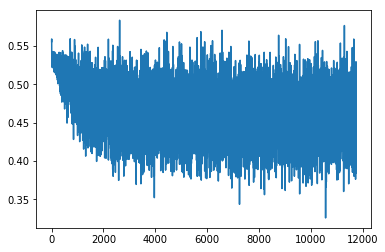

In [472]:
plt.figure()
plt.plot(all_losses)

## Evaluation

In [473]:
correct = 0
correct_neg = 0
correct_pos = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        items, users, neg_samp = data
        img, d = tensor_img[items], word2id_pad[items]
        batch_size = items.size(0)
        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        outputs_pos = R(items, users, d, img)
        loss_neg = torch.tensor([0.])
        for i_neg in neg_samp.t():
            img_neg, d_neg = tensor_img[i_neg], word2id_pad[i_neg]
            outputs_neg = R(i_neg, users, d, img_neg)
            loss_neg += criterion(outputs_neg, neg_target)
            
        total += pos_target.size(0)
        correct_pos += criterion(outputs_pos, pos_target).item()
        correct_neg += (loss_neg / 5.).item()

In [474]:
(correct_pos + correct_neg) / (total*2)

0.014449088406283657

In [475]:
correct_neg, correct_pos

(137.06548443436623, 134.43288671970367)

In [476]:
args = (test_data.dataset.itemId[test_data.indices], 
        test_data.dataset.userId[test_data.indices], 
        word2id_pad[test_data.dataset.itemId[test_data.indices]],
        tensor_img[test_data.dataset.itemId[test_data.indices]],  
       )
n = test_data.dataset.n

In [477]:
sum((nn.Sigmoid()(R(*args))).round()).item() / total

0.7522086216072379

## Recommendation

In [478]:
def reco(user):
    movieid_list = list(ratings_df.movieId.unique())
    movieid_user_list = list(ratings_df[ratings_df.userId == user].movieId)
    items = torch.Tensor([m for m in movieid_list if m not in movieid_user_list]).long()
    size = items.shape[0]
    args_reco = (items, 
        torch.ones(size).long(), 
        word2id_pad[items],
        tensor_img[items],  
       )
    return nn.Sigmoid()(R(*args_reco))

In [409]:
pd.options.mode.chained_assignment = None

In [479]:
user = 500
n_reco = 50
reco_user = reco(user)
reco_top10 = torch.argsort(reco_user, dim=0, descending=True)[:n_reco].view(n_reco)
score_reco = torch.sort(reco_user, dim=0, descending=True)[0][:n_reco].view(n_reco)
set_reco = [imdb2id[movie_list[i]] for i in reco_top10]
a = movies_df.query("movieId in @set_reco")
a['score'] = score_reco.detach().numpy()
set_u = [imdb2id[movie_list[i]] for i in list(ratings_df[ratings_df.userId == user].movieId)]
u_movies = movies_df.query("movieId in @set_u")

In [480]:
u_movies.sample(6)

,movieId,title,genres
2028,2700,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical
1570,2108,L.A. Story (1991),Comedy|Romance
2259,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy
1322,1784,As Good as It Gets (1997),Comedy|Drama|Romance
1404,1923,There's Something About Mary (1998),Comedy|Romance
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


In [481]:
a.sample(6)

,movieId,title,genres,score
5372,8958,Ray (2004),Drama,0.861675
1687,2268,"Few Good Men, A (1992)",Crime|Drama|Thriller,0.887539
23,24,Powder (1995),Drama|Sci-Fi,0.972068
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.920881
2372,3147,"Green Mile, The (1999)",Crime|Drama,0.877669
668,880,"Island of Dr. Moreau, The (1996)",Sci-Fi|Thriller,0.902792


In [467]:
torch.sort(reco_user, dim=0, descending=True)[0][-100:]

tensor([[0.4617],
        [0.4610],
        [0.4605],
        [0.4605],
        [0.4595],
        [0.4583],
        [0.4577],
        [0.4575],
        [0.4571],
        [0.4566],
        [0.4563],
        [0.4559],
        [0.4550],
        [0.4549],
        [0.4544],
        [0.4540],
        [0.4537],
        [0.4536],
        [0.4535],
        [0.4526],
        [0.4525],
        [0.4523],
        [0.4519],
        [0.4515],
        [0.4512],
        [0.4508],
        [0.4506],
        [0.4506],
        [0.4492],
        [0.4488],
        [0.4483],
        [0.4472],
        [0.4471],
        [0.4471],
        [0.4469],
        [0.4467],
        [0.4464],
        [0.4459],
        [0.4458],
        [0.4454],
        [0.4444],
        [0.4434],
        [0.4420],
        [0.4415],
        [0.4410],
        [0.4406],
        [0.4405],
        [0.4403],
        [0.4381],
        [0.4370],
        [0.4370],
        [0.4368],
        [0.4367],
        [0.4358],
        [0.4351],
        [0